# [IAPR 2019:][iapr2019] Special project

**Group members:**
    1- Maxim Bianchini,
    2- Emmanuel Nieto,
    3- Patrick Sgrò

**Due date:** 30.05.2019

[iapr2019]: https://github.com/LTS5/iapr-2019


## Description
Please find the description of this special project via [this link].

[this link]: https://github.com/LTS5/iapr-2019/blob/master/project/special_project_description.pdf

In [7]:
import tarfile
import os
import numpy as np

import skimage.io
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

import math
import skimage.color


data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'project-data'
tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')

with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)


import xml.etree.ElementTree as ET

def parse_file(filename):
    """ Parse a PASCAL VOC xml file """
    tree = ET.parse(filename)
    objects = []
    for obj in tree.findall('object'):
        obj_struct = {}
        obj_struct['name'] = obj.find('name').text
        bbox = obj.find('bndbox')
        obj_struct['bbox'] = [int(float(bbox.find('xmin').text)),
                              int(float(bbox.find('ymin').text)),
                              int(float(bbox.find('xmax').text))-int(float(bbox.find('xmin').text)),
                              int(float(bbox.find('ymax').text))-int(float(bbox.find('ymin').text))]
        objects.append(obj_struct)

    return objects



# Load images
def load_images(type_im, data_base_path, data_folder):
    file_ = open(os.path.join(data_base_path, data_folder, type_im + ".txt"), "r")
    im_names = []
    name_i = file_.readline()
    im_names.append(name_i[0:(len(name_i)-1)])
    while (name_i):
        name_i = file_.readline()
        if name_i :
            if name_i[len(name_i)-1] == '\n':
                im_names.append(name_i[0:(len(name_i)-1)])
            else:
                im_names.append(name_i)

    filenames = [os.path.join(data_base_path, data_folder,"images", type_im, name) + '.jpg' for name in im_names]
    images = skimage.io.imread_collection(filenames)
    print('The number of images in ', type_im, ' is: ', len(images))
    
    annotations_xmls = [parse_file(os.path.join(data_base_path, data_folder,"annotations", type_im, name) + '.xml') for name in im_names]
    
    return im_names, images, annotations_xmls


In [223]:
# **** type_im = test, train, validation ****
test_im_names, test_images, test_annotations_xmls = load_images("test", data_base_path, data_folder)
train_im_names, train_images, train_annotations_xmls = load_images("train", data_base_path, data_folder)
valid_im_names, valid_images, valid_annotations_xmls = load_images("validation", data_base_path, data_folder)
_, test_images_all, _= load_images("test", data_base_path, data_folder)
_, train_images_all, _ = load_images("train", data_base_path, data_folder)

The number of images in  test  is:  50
The number of images in  train  is:  800
The number of images in  validation  is:  150


In [8]:
def IoU_eval(annotations, detected_varroas):
    
    IoU = []
    for k1 in range(0,len(annotations)):
        # We get the informations of the rectangles
        A_xmin = annotations[k1]['bbox'][0]
        A_ymin = annotations[k1]['bbox'][1]
        A_w = annotations[k1]['bbox'][2]
        A_h = annotations[k1]['bbox'][3]
        A_xmax = A_xmin+A_w
        A_ymax = A_ymin+A_h
        
        IoU_k2 = []
        for k2 in range(0,len(detected_varroas)):
            B_xmin = detected_varroas[k2, 0]
            B_ymin = detected_varroas[k2, 1]
            B_w = detected_varroas[k2, 2]
            B_h = detected_varroas[k2, 3]
            B_xmax = B_xmin+B_w
            B_ymax = B_ymin+B_h
            
            inter = 0
            if (A_xmin <= B_xmin <= A_xmax):
                if (A_ymin <= B_ymin <= A_ymax):
                    inter = (min(A_xmax, B_xmax) - B_xmin)*(min(A_ymax, B_ymax) - B_ymin)
                elif (A_ymin <= B_ymax <= A_ymax):
                    inter = (min(A_xmax, B_xmax) - B_xmin)*(B_ymax - A_ymin)
                    
            elif (A_xmin <= B_xmax <= A_xmax):
                if (A_ymin <= B_ymin <= A_ymax):
                    inter = (B_xmax - A_xmin)*(min(A_ymax, B_ymax) - B_ymin)
                elif (A_ymin <= B_ymax <= A_ymax):
                    inter = (B_xmax - A_xmin)*(B_ymax - A_ymin)
                    
            union = A_w*A_h + B_w*B_h
            IoU_k2.append(inter/union)
            
        if IoU_k2:
            IoU.append(max(IoU_k2))
        else:
            IoU.append(0)  
    
    return IoU
    

def number_of_TP_FP_FN_eval(IoU, T, nbr_detected_varroas):
    # return the number of TP FP and FN
    TP = 0
    FN = 0
    for k in range(0,len(IoU)):
        if IoU[k]>T :
            TP = TP + 1
        else :
            FN = FN + 1
    
    FP = nbr_detected_varroas - TP
    
    return TP, FP, FN

def precision_recall_F1score_eval(TP, FP, FN):
    if (TP+FP)==0:
        prec = 1
    else:
        prec = TP/(TP+FP)
    if (TP+FN)==0:
        rec = 1
    else:
        rec = TP/(TP+FN)
    
    if prec+rec != 0 :
        F1 = 2*prec*rec/(prec+rec)
    else :
        F1 = 0

    return prec, rec, F1



## Part 1: Finding varroas by segmentation
Add your implementation for ''**detect_by_segmentation**'' function. Please make sure the input and output follows the mentioned format.

In [9]:
from skimage.measure import label, regionprops
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()  # for plot styling
import numpy as np
from skimage.morphology import disk, square
from skimage import feature
from skimage.filters import threshold_otsu

# Function that rescales the intensity value and sets it between 0 and 255
def rescale_intensity(image):
    y_im, x_im, z_im = image.shape
    out = image.copy()
    for i in range(0,z_im):
        image2 = image[:,:,i]
        minimum = np.min(image2)
        maximum = np.max(image2)
        out[:,:,i]=(image2 - minimum)/(maximum-minimum)*255
    return out


def inverse_image(image):
    # This function only works for thresholded images and it inverses the blak pixels with the white pixels and vice versa.
    # It is usefull when we use morphological operations because they work on the logical ones and not on the zeros.
    out = image.copy()
    y_image, x_image = image.shape
    for x in range(0,x_image):
        for y in range(0,y_image):
            if image[y,x]==0:
                out[y,x]=255
            else:
                out[y,x]=0
    return out

def extract_varroa(image_lab, label_varroa):
    # This function extracts the varroa having the label "label_varroa" on the image "i"
    # The output is a thresholded image with the varroa's pixels in black, the function also returns the number 
    # of pixels of this varroa
    image = image_lab.copy()
    y_image, x_image = image.shape
    for x in range(0,x_image):
        # This is an inversed threshold, because the morphological operations are working on the true values
        for y in range(0,y_image):
            if image_lab[y,x] == label_varroa:
                image[y,x] = 255
            else:
                image[y,x] = 0
    # We applie a dilation because previously we applied an erosion in order to separate the superposed varroas
    # and now we would like to obtain the entire varroa
    image = skimage.morphology.dilation(image,disk(int(varona_size*0.75)))
    
    # After the morphological operation we reverse the image
    image = inverse_image(image)
    
    
    x_min = x_image
    x_max = 0
    y_min = y_image
    y_max = 0
    for x in range(0,x_image):
        for y in range(0,y_image):
            if image[y,x]==0:
                if x < x_min:
                    x_min = x
                if x > x_max:
                    x_max = x
                if y < y_min:
                    y_min = y
                if y > y_max:
                    y_max = y
    
    h_old = (y_max-y_min)
    w_old = (x_max-x_min)
    increment = 1.7
    h = (y_max-y_min)*increment
    w = (x_max-x_min)*increment
    x_min = x_min+w_old/2-w/2
    y_min = y_min+h_old/2-h/2
    
    return int(x_min), int(y_min), int(w), int(h)

little_hole = 4
varona_size = 11

In [10]:
def detect_by_segmentation(img):
    # the index is used only in order to plot the image with the rectangles
    '''
    Input: One single image
    Output: A numpy array containing coordonates of all detected varroas, with the following format: 
            [[x_1, y_1, w_1, h_2], [x_2, y_2, w_1, h_2], ..., [x_n, y_n, w_n, h_n]] 
            where ''n'' is the number of detected varroas.
    '''
    
    img= rescale_intensity(img)
     
    img2 = np.uint8((img[:,:,0]/3*2+img[:,:,1]/3)).copy()
    #img2= skimage.exposure.rescale_intensity(img2)

    img2 = skimage.filters.median(img2, disk(3))
    
    
    thresh = 90
    img_thresh = img2 > thresh
    img_thresh = skimage.filters.median(img_thresh, disk(3))
    

    # We inverse the image because the morphological operations work only on the true elements and not with
    # the false
    image = inverse_image(img_thresh.astype(int)*255)

    # We close the little holes present in the varroas
    image = skimage.morphology.closing(image,square(little_hole))

    # We open with a circle a bit bigger than the varroa size and we subtract it from the original image
    # with this apprach we eliminate the parts bigger than a varroa
    image = image - skimage.morphology.opening(image,disk(int(varona_size*1.4)))

    # We open with a circle a bit smaller than the size of the varroa, like this all the parts smaller than a varroa are deleted
    image_morph = skimage.morphology.opening(image,disk(int(varona_size*0.75)))

    # In order to label correctly the varroas they don't have to be superposed and we do an erosion with
    # a circle smaller than the size of the varroa
    image = skimage.morphology.erosion(image_morph,disk(int(varona_size*0.75)))

    image = inverse_image(image)
    image_thresholded2 = image.copy()
    image_thresholded2 = image.astype(int)*255
    
    
    image_labeled = skimage.measure.label(image_thresholded2, connectivity=2, background=255)

    nbr_varroas = np.max(image_labeled) - 1
    
    if (nbr_varroas>90):
        print("the choosed image is not good")
        detected_varroas =[]
    else:
        print("the number of detected varroas is ", nbr_varroas)

        # for label_varroa from 2 to nbr_varroas+1
        if nbr_varroas > 1:
            detected_varroas = np.array([extract_varroa(image_labeled, 2)])
            for label_varroa in range(3,nbr_varroas+2):
                b = np.array([extract_varroa(image_labeled, label_varroa)])
                detected_varroas = np.append(detected_varroas,b, axis=0)
        else:
            detected_varroas = []
    
    
    return detected_varroas
    

In [ ]:
# DO NOT RUN THIS CODE - it takes time
# This script is used to search the varroas by segmentation and it saves the rectangles ("detected_varroa_part1") in the file 'detected_varroa_part1.npz'.

detected_varroa_part1 = []
for index in range(0,len(test_images)):
    detected_varroa_part1.append(detect_by_segmentation(test_images[index]))

detected_varroa_part1 = np.array(detected_varroa_part1)
np.savez('detected_varroa_part1.npz', name1=detected_varroa_part1)

In [11]:
# This script is used to compute the precision, the recall and the F1 score for the segmentation.

data = np.load('detected_varroa_part1.npz')
detected_varroa_part1_ = data['name1']

IoU = []
TP = []
FP = []
FN = []
prec = []
rec = []
F1 = []
for index in range(0,len(test_images)):
    IoU_i = IoU_eval(test_annotations_xmls[index], detected_varroa_part1_[index])
    TP_i, FP_i, FN_i =  number_of_TP_FP_FN_eval(IoU_i, 0.3, len(detected_varroa_part1_[index]))
    prec_i, rec_i, F1_i = precision_recall_F1score_eval(TP_i, FP_i, FN_i)
    IoU.append(IoU_i)
    TP.append(TP_i)
    FP.append(FP_i)
    FN.append(FN_i)
    prec.append(prec_i)
    rec.append(rec_i)
    F1.append(F1_i)
prec_av = np.mean(prec)
rec_av = np.mean(rec)
F1_av = np.mean(F1)

print("precision: ", prec_av)
print("recall: ", rec_av)
print("F1: ", F1_av)

precision:  0.29214038783179824
recall:  0.4388934158572085
F1:  0.1934214263785285


## Part 2: Implement your first detector

Write your function(s) for the second part. Feel free to change the name of the function and add your additional functions, but please make sure their input and output follows the mentioned format.

In [383]:
def contour_2_fourier(vector):
    vector_complex = []
    N = len(vector)
    for n in range(0,N):
        vector_complex.append(complex(vector[n][0],vector[n][1]))
    
    nbr_features = 4
    
    temp = np.fft.fft(vector_complex)
    
    if len(temp)<=2:
        feature1 = 0
        feature2 = 0
    else:
        harmonic1 = abs(temp[1])
        harmonic2 = abs(temp[2])

        feature1 = harmonic1
        feature2 = harmonic2
    
    """
    if we want to be scaling independent we must use this code:
    harmonic3 = abs(temp[3])
    feature1 = harmonic1/harmonic3
    feature2 = harmonic2/harmonic3
    """
    return feature1, feature2

def inverse_image(image):
    # This function only works for thresholded images and it inverses the blak pixels with the white pixels and vice versa.
    # It is usefull when we use morphological operations because they work on the logical ones and not on the zeros.
    out = image.copy()
    y_image, x_image = image.shape
    for x in range(0,x_image):
        for y in range(0,y_image):
            if image[y,x]==0:
                out[y,x]=255
            else:
                out[y,x]=0
    return out

def contour_2_varroa_coordinates(contour):
    x_min = np.min(contour[:,0])
    x_max = np.max(contour[:,0])
    y_min = np.min(contour[:,1])
    y_max = np.max(contour[:,1])
    
    h_old = (y_max-y_min)
    w_old = (x_max-x_min)
    increment = 1.7
    h = (y_max-y_min)*increment
    w = (x_max-x_min)*increment
    x_min = x_min+w_old/2-w/2
    y_min = y_min+h_old/2-h/2
    
    
    return int(x_min), int(y_min), int(w), int(h)

    

In [289]:
# FUNCTIONS FOR TRAINING

# Lableing function used only to train the Gaussians on the train dataset
def labeling(annotations, detected_contours):
    
    label = []
    for k1 in range(0,len(detected_contours)):
        # We get the informations of the rectangles
        A_xmin = detected_contours[k1][0]
        A_ymin = detected_contours[k1][1]
        A_w = detected_contours[k1][2]
        A_h = detected_contours[k1][3]
        A_xmax = A_xmin+A_w
        A_ymax = A_ymin+A_h
        
        IoU_k2 = []
        for k2 in range(0,len(annotations)):
            B_xmin = annotations[k2]['bbox'][0]
            B_ymin = annotations[k2]['bbox'][1]
            B_w = annotations[k2]['bbox'][2]
            B_h = annotations[k2]['bbox'][3]
            B_xmax = B_xmin+B_w
            B_ymax = B_ymin+B_h
            inter = 0
            if (A_xmin <= B_xmin <= A_xmax):
                if (A_ymin <= B_ymin <= A_ymax):
                    inter = (min(A_xmax, B_xmax) - B_xmin)*(min(A_ymax, B_ymax) - B_ymin)
                elif (A_ymin <= B_ymax <= A_ymax):
                    inter = (min(A_xmax, B_xmax) - B_xmin)*(B_ymax - A_ymin)
                    
            elif (A_xmin <= B_xmax <= A_xmax):
                if (A_ymin <= B_ymin <= A_ymax):
                    inter = (B_xmax - A_xmin)*(min(A_ymax, B_ymax) - B_ymin)
                elif (A_ymin <= B_ymax <= A_ymax):
                    inter = (B_xmax - A_xmin)*(B_ymax - A_ymin)
                    
            union = A_w*A_h + B_w*B_h
            IoU_k2.append(inter/union)
            
        if IoU_k2:
            label.append(max(IoU_k2)>0.01)
        else:
            label.append(0)
    
    return label


# This function is used for the training of the Gaussians to detect the varroas afterwards
def detect_by_Fourier(img, annotations):
    '''
    Input: One single image
    Output: A numpy array containing coordonates of all detected varroas, with the following format: 
            [[x_1, y_1, w_1, h_2], [x_2, y_2, w_1, h_2], ..., [x_n, y_n, w_n, h_n]] 
            where ''n'' is the number of detected varroas.
    '''
    
    img= rescale_intensity(img)
     
    img2 = np.uint8((img[:,:,0]/3*2+img[:,:,1]/3)).copy()
    
    img2 = skimage.filters.median(img2, disk(3))
    
    thresh = 90
    img_thresh = img2 > thresh
    img_thresh = skimage.filters.median(img_thresh, disk(3))
     
    img_ = img_thresh
    
    contour = measure.find_contours(img_, 0.5)
   
    av_r_vector = []
    for i in range(len(contour)):
        # in order to inverter the x with the y
        tmp0 = contour[i][:,1].copy()
        tmp1 = contour[i][:,0].copy()
        contour[i][:,0] = tmp0.copy()
        contour[i][:,1] = tmp1.copy()

        # in order to extract the mean value of the
        av_r = 0
        c = 0
        for x in range(math.floor(np.min(contour[i][:,0])),math.ceil(np.max(contour[i][:,0]))):
            for y in range(int(np.min(contour[i][:,1])),int(np.max(contour[i][:,1]))):
                av_r = av_r + np.array(img[y,x,0])
                c = c+1
        if c == 0:
            av_r_vector = np.append(av_r_vector, 0)
        else:
            av_r_vector = np.append(av_r_vector, av_r/c)
    
    
    # Transformation from a detected contour to coordinate of the contour.
    detected_contours = []
    for i in range(len(contour)):
        detected_contours.append(contour_2_varroa_coordinates(contour[i]))
    # use IoU to label which contour corresponds to a varroa
    label = labeling(annotations, detected_contours)
    
    # GMM per la classificazione
    
    dataset = np.zeros((len(contour),3))
    for i in range(len(contour)):
        dataset[i,0], dataset[i,1] = contour_2_fourier(contour[i])
    
    dataset[:,2] = av_r_vector
    
    return dataset, label
    

In [328]:
# FUNCTIONS USED IN BAYESIAN CLASSIFICATION

#Definition of the discriminant functions
def g_i(mu,sigma,x,prior):
    #Cacluclation of the inverse Covariance matrices
    sigma_inv = np.linalg.inv(sigma)
    
    #To help: we define the transpose
    x_t = np.transpose(x)
    mu_t = np.transpose(mu)
    
    
    c = np.log(1/(2*math.pi*np.sqrt(np.linalg.det(sigma))))
    g = -0.5*x@sigma_inv@x_t + 0.5*x@sigma_inv@mu_t - 0.5*mu@sigma_inv@mu_t + 0.5*mu@sigma_inv@x_t + np.log(prior) + c
    #g = -0.5*x_t*sigma_inv*x + 0.5*x_t*sigma_inv*mu - 0.5*mu_t*sigma_inv*mu + 0.5*mu_t*sigma_inv*x + np.log(prior)
    
    return g


#Bayesian Classification
def Gaussians(dataset, label):
    
    data_varroa = np.array([[],[],[]]).T
    data_else = np.array([[],[],[]]).T
    print(np.array([dataset[0,:]]).shape)
    # assign all datapoints to varroa or not
    for i in range(len(label)):
        if label[i]==True:
            data_varroa = np.append(data_varroa, np.array([dataset[i,:]]),axis=0)
        else:
            data_else = np.append(data_else, np.array([dataset[i,:]]),axis=0)
    
    print(data_varroa.shape)
    print(data_else.shape)
    """fig, ax = plt.subplots(1, 1, figsize=(15.5, 6))
    plt.scatter(data_varroa[:,0],data_varroa[:,1],c="b",s=10)
    plt.scatter(data_else[:,0],data_else[:,1],c="g",s=1)
    plt.show()"""
    
    #Prior assignment
    Prior_varroa = len(data_varroa)/(len(data_varroa)+len(data_else))
    Prior_else = len(data_else)/(len(data_varroa)+len(data_else))
    
    Sigma_varroa = np.cov(np.transpose(data_varroa))
    Mean_varroa = np.array([np.mean(data_varroa,axis=0)])
    Sigma_else = np.cov(np.transpose(data_else))
    Mean_else = np.array([np.mean(data_else,axis=0)])
    
    return Mean_varroa, Sigma_varroa, Prior_varroa, Mean_else, Sigma_else, Prior_else

def is_varroa(Mean_varroa, Sigma_varroa, Prior_varroa, Mean_else, Sigma_else, Prior_else, x):
    
    g_varroa = g_i(Mean_varroa,Sigma_varroa,x,Prior_varroa)
    g_else = g_i(Mean_else,Sigma_else,x,Prior_else)
    
    if g_varroa >= g_else:
        return 1
    else:
        return 0

In [ ]:
#DO NOT RUN THIS CODE - It takes time -> use dataset_array.txt and label.pckl instead

import pickle
import skimage.measure as measure

index = 0
dataset_array, label_array = detect_by_Fourier(train_images[index], train_annotations_xmls[index])
for index in range(1, len(train_images)):
    dataset, label = detect_by_Fourier(train_images[index], train_annotations_xmls[index])
    label_array = [*label_array, *label]
    dataset_array = np.append(dataset_array, dataset,axis=0)
    print(index)

np.savetxt('dataset_array.txt', dataset_array, fmt='%f') # 

f = open('label.pckl', 'wb')
pickle.dump(label_array, f)
f.close()

In [ ]:
#DO NOT RUN THIS CODE - It takes time, use variables_GMM.npz instead

import math
import pickle

dataset_array = np.loadtxt('dataset_array.txt', dtype=float)

f = open('label.pckl', 'rb')
label_array = pickle.load(f)
f.close()

Mean_varroa, Sigma_varroa, Prior_varroa, Mean_else, Sigma_else, Prior_else = Gaussians(dataset_array, label_array)

np.savez('variables_GMM.npz', name1=Mean_varroa, name2=Sigma_varroa, name3=Prior_varroa, name4=Mean_else, name5=Sigma_else, name6=Prior_else)


In [349]:
#Fourier descriptors + mean of red color on the rectangle used to classify

def detect_by_Fourier_test(img):
    '''
    Input: One single image
    Output: A numpy array containing coordonates of all detected varroas, with the following format: 
            [[x_1, y_1, w_1, h_2], [x_2, y_2, w_1, h_2], ..., [x_n, y_n, w_n, h_n]] 
            where ''n'' is the number of detected varroas.
    '''
    
    img= rescale_intensity(img)
     
    img2 = np.uint8((img[:,:,0]/3*2+img[:,:,1]/3)).copy()
    #img2= skimage.exposure.rescale_intensity(img2)

    img2 = skimage.filters.median(img2, disk(3))
    
    
    thresh = 90
    img_thresh = img2 > thresh
    img_thresh = skimage.filters.median(img_thresh, disk(3))
    
    img_ = img_thresh
    
    contour = measure.find_contours(img_, 0.5)
   
    av_r_vector = []
    for i in range(len(contour)):
        # in order to inverter the x with the y
        tmp0 = contour[i][:,1].copy()
        tmp1 = contour[i][:,0].copy()
        contour[i][:,0] = tmp0.copy()
        contour[i][:,1] = tmp1.copy()

        # in order to extract the mean value of the
        av_r = 0
        c = 0
        for x in range(math.floor(np.min(contour[i][:,0])),math.ceil(np.max(contour[i][:,0]))):
            for y in range(int(np.min(contour[i][:,1])),int(np.max(contour[i][:,1]))):
                av_r = av_r + np.array(img[y,x,0])
                c = c+1
        if c == 0:
            av_r_vector = np.append(av_r_vector, 0)
        else:
            av_r_vector = np.append(av_r_vector, av_r/c)
    
    
    # GMM for the classification
    data = np.load('variables_GMM.npz')
    Mean_varroa = data['name1']
    Sigma_varroa = data['name2']
    Prior_varroa = data['name3']
    Mean_else = data['name4']
    Sigma_else = data['name5']
    Prior_else = data['name6']
    
    
    detected_varroas = []
    
    for i in range(len(contour)):
        x = contour_2_fourier(contour[i])
        if(is_varroa(Mean_varroa, Sigma_varroa, Prior_varroa, Mean_else, Sigma_else, Prior_else, np.array([[x[0],x[1],av_r_vector[i]]]))==1):
            detected_varroas.append(contour_2_varroa_coordinates(contour[i]))
        #if(is_varroa(Mean_varroa, Sigma_varroa, 0.49, Mean_else, Sigma_else, 0.51, np.array([[x[0],x[1],av_r_vector[i]]]))==1):
         #   detected_varroas.append(contour[i])

        
    return np.array(detected_varroas)
            
            

In [ ]:
#DON NOT RUN THIS CODE - It takes time -> use in the following cell detected_varroa_part2.npz instead

det_Part2 = []
for index in range(0,len(valid_images)):
    det_Part2.append(detect_by_Fourier_test(valid_images[index]))
    print(index)


print(len(det_Part2))

np.savez('detected_varroa_part2.npz', name1=det_Part2)


In [389]:
data = np.load('detected_varroa_part2.npz')
det_Part2 = data['name1']

IoU = []
TP = []
FP = []
FN = []
prec = []
rec = []
F1 = []
for index in range(0,len(det_Part2)):
    IoU_i = IoU_eval(valid_annotations_xmls[index], det_Part2[index])
    TP_i, FP_i, FN_i =  number_of_TP_FP_FN_eval(IoU_i, 0.3, len(det_Part2[index]))
    prec_i, rec_i, F1_i = precision_recall_F1score_eval(TP_i, FP_i, FN_i)
    IoU.append(IoU_i)
    TP.append(TP_i)
    FP.append(FP_i)
    FN.append(FN_i)
    prec.append(prec_i)
    rec.append(rec_i)
    F1.append(F1_i)
prec_av = np.mean(prec)
rec_av = np.mean(rec)
F1_av = np.mean(F1)

print("precision: ", prec_av)
print("recall: ", rec_av)
print("F1: ", F1_av)

precision:  0.014823007244027932
recall:  0.4195275009215604
F1:  0.019800914373082446


## Part 3: Using MLP and CNNs

Add your implementation for the thrid part. Feel free to add your desirable functions, but please make sure you have proper functions for the final detection, where their input and output follows the same format as the previous parts.

In [52]:
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import gzip
from sklearn.metrics import confusion_matrix

import tarfile
import scipy.io
import skimage.io
import matplotlib.patches as patches
import math
import skimage.color

def plot_images(i,a):
    fig, axes = plt.subplots(2, 2, figsize=(12, 12))
    for a1, ax in zip(range (i,i+4),axes.ravel()):
        if a == 0 :
            im = test_images_all[a1] 
            nm = test_im_names [a1]
            annotations = test_annotations_xmls[a1]
        elif a == 1 : 
            im = train_images_all[a1] 
            nm = train_im_names [a1]
            annotations = train_annotations_xmls[a1]
        else : 
            im = valid_images[a1] 
            nm = valid_im_names [a1]
            annotations = valid_annotations_xmls[a1]
            
        # Iterate over annotations
        for anno in annotations:
            rect = patches.Rectangle((anno['bbox'][0], anno['bbox'][1]), anno['bbox'][2], anno['bbox'][3],
                    linewidth=1,edgecolor='r',facecolor='none')
            ax.add_patch(rect)

        ax.imshow(im)
        ax.axis('off')
        ax.set_title(nm)
    plt.show()

# plot_images(3,2)

def plot_images_labels(i,a,labels_):
    a1 = i
    fig, ax = plt.subplots(1, 1, figsize=(12, 12))
    if a == 0 :
        im = test_images_all[a1] 
        nm = test_im_names [a1]
        annotations = test_annotations_xmls[a1]
    elif a == 1 : 
        im = train_images_all[a1] 
        nm = train_im_names [a1]
        annotations = train_annotations_xmls[a1]
    else : 
        im = valid_images[a1] 
        nm = valid_im_names [a1]
        annotations = valid_annotations_xmls[a1]

    # Iterate over annotations
    for anno in annotations:
        rect = patches.Rectangle((anno['bbox'][0], anno['bbox'][1]), anno['bbox'][2], anno['bbox'][3],
                linewidth=1,edgecolor='r',facecolor='none')
        ax.add_patch(rect)
    for anno in labels:
        rect = patches.Rectangle((anno[0], anno[1]), anno[2], anno[3],
                linewidth=1,edgecolor='b',facecolor='none')
        ax.add_patch(rect)
        
    ax.imshow(im)
    ax.axis('off')
    ax.set_title(nm)
    plt.show()


In [14]:
# generate train set
window_size = 60 #n of side pixels of square window
n_channels = 3
train_size = 20000
n_train_labels = 2
perc = 15 #1/perc*100%

indices = np.random.choice(range(np.shape(train_annotations_xmls)[0]),train_size//2)

train_images = np.zeros([train_size,window_size*window_size*n_channels])
train_labels = np.zeros([train_size,n_train_labels])

counter_labels = 0
for index, a1 in zip(indices, range(0,train_size//2)):
    
    annotation = train_annotations_xmls[index];
    train_labels[a1] = [0,1]
    train_labels[a1+train_size//2] = [0,1]

    if counter_labels < train_size/perc and np.shape(annotation)[0] > 0:
        indexaux = np.random.choice(range(np.shape(annotation)[0]),1)[0]
        randx = annotation[indexaux]['bbox'][0] - np.random.choice(range(window_size-annotation[indexaux]['bbox'][2]),1)[0]#the rectangles are in x first then y
        randy = annotation[indexaux]['bbox'][1] - np.random.choice(range(window_size-annotation[indexaux]['bbox'][3]),1)[0]

        lenx=np.shape(train_images_all[index])[1]
        leny=np.shape(train_images_all[index])[0]
        if randx < 0:
            randx = 0
        if randx + window_size >= lenx:
            randx = lenx - window_size;

        if randy < 0:
            randy = 0
        if randy + window_size >= leny:
            randy = leny - window_size;


        maux = train_images_all[index][randy:randy+window_size,randx:randx+window_size,:]
        train_images[a1]= np.ndarray.flatten(maux)
        train_images[a1+train_size//2]=np.ndarray.flatten(maux[:,::-1,:])
        train_labels[a1] = [1,0]
        train_labels[a1+train_size//2] = [1,0]
        counter_labels += 1

    else:
        randx = np.random.choice(range(np.shape(train_images_all[index])[1]-window_size),1)[0]
        randy = np.random.choice(range(np.shape(train_images_all[index])[0]-window_size),1)[0]
        
        maux = train_images_all[index][randy:randy+window_size,randx:randx+window_size,:]
        train_images[a1] = np.ndarray.flatten(maux)
        train_images[a1+train_size//2]=np.ndarray.flatten(maux[:,::-1,:])


        if np.shape(annotation)[0] > 0:
            for ann in annotation:
                if ann['bbox'][1] > randy and ann['bbox'][1]+ann['bbox'][3] < randy+window_size and ann['bbox'][0] > randx and ann['bbox'][0]+ann['bbox'][2] < randx+window_size:
                    counter_labels += 1
                    train_labels[a1] = [1,0]
                    train_labels[a1+train_size//2] = [1,0]
                    break
# generate test images
test_size = 1000
n_test_labels = 2

indices = np.random.choice(range(np.shape(valid_annotations_xmls)[0]),test_size)

test_images = np.zeros([test_size,window_size*window_size*n_channels])
test_labels = np.zeros([test_size,n_test_labels])

counter_labels = 0
for index, a1 in zip(indices, range(0,test_size)):
    
    annotation = valid_annotations_xmls[index];
    test_labels[a1] = [0,1]

    if counter_labels < test_size/perc and np.shape(annotation)[0] > 0:
        indexaux = np.random.choice(range(np.shape(annotation)[0]),1)[0]
        randx = annotation[indexaux]['bbox'][0] - np.random.choice(range(window_size-annotation[indexaux]['bbox'][2]),1)[0]#the rectangles are in x first then y
        randy = annotation[indexaux]['bbox'][1] - np.random.choice(range(window_size-annotation[indexaux]['bbox'][3]),1)[0]

        lenx=np.shape(valid_images[index])[1]
        leny=np.shape(valid_images[index])[0]
        if randx < 0:
            randx = 0
        if randx + window_size >= lenx:
            randx = lenx - window_size;

        if randy < 0:
            randy = 0
        if randy + window_size >= leny:
            randy = leny - window_size;


        test_images[a1]= np.ndarray.flatten(valid_images[index][randy:randy+window_size,randx:randx+window_size,:])
        test_labels[a1] = [1,0]
        counter_labels += 1

    else:
        randx = np.random.choice(range(np.shape(valid_images[index])[1]-window_size),1)[0]
        randy = np.random.choice(range(np.shape(valid_images[index])[0]-window_size),1)[0]
        test_images[a1] = np.ndarray.flatten(valid_images[index][randy:randy+window_size,randx:randx+window_size,:])

        if np.shape(annotation)[0] > 0:
            for ann in annotation:
                if ann['bbox'][1] > randy and ann['bbox'][1]+ann['bbox'][3] < randy+window_size and ann['bbox'][0] > randx and ann['bbox'][0]+ann['bbox'][2] < randx+window_size:
                    counter_labels += 1
                    test_labels[a1] = [1,0]
                    break


In [15]:
maxx = 0
maxy = 0
for annotations in train_annotations_xmls:
    # Iterate over annotations
    for anno in annotations:
        if maxx < anno['bbox'][2]:
            maxx = anno['bbox'][2]
        if maxy < anno['bbox'][3]:
            maxy = anno['bbox'][3]

print(maxx, maxy)
        

56 52


In [28]:
# Display the openend files
# image_shape = (28, 28)
train_set_size = 50
# test_set_size = 10000

#Define the number of nodes for the hidden layers
hidden_nodes_1=256
hidden_nodes_2=512
batch_size = 25


num_labels = 2
ndiv = 2 #n for dividing and sliding the window
n_labels = 2


MLP_GRAPH = tf.Graph()

with MLP_GRAPH.as_default():
    """
        For the training data we use place holders in order to feed them
        in the run time with those mini bitches :D
    """
    TF_TRAIN_DATASET = tf.placeholder(tf.float32, shape=(None, window_size * window_size*n_channels))
    TF_TRAIN_LABELS = tf.placeholder(tf.float32, shape=(None, num_labels))
#     TF_TEST_DATASET = tf.placeholder(tf.float32, shape=(None, window_size * window_size*n_channels))
    TF_TEST_DATASET = tf.cast(tf.constant(test_images), tf.float32)

    """
       The first hidden layer with 1024 nodes
    """
    
    with tf.name_scope("FirstHidden"):
        """
            Initialize the hidden weights and biases
        """
        HIDDEN_WEIGHTS_1=tf.Variable(tf.random_normal(shape=[window_size * window_size*n_channels, hidden_nodes_1], stddev=0.1))
        HIDDEN_BIASES_1 =tf.Variable(tf.random_normal(shape=[hidden_nodes_1], stddev=0.1))

        """
            Compute the logits WX + b and then apply D(S(WX + b), L) on them for the hidden layer
            The relu is applied on the hidden layer nodes only
        """
        TRAIN_HIDDEN_LOGITS_1 = tf.nn.relu(tf.matmul(TF_TRAIN_DATASET, HIDDEN_WEIGHTS_1) + HIDDEN_BIASES_1)
        TEST_HIDDEN_LOGITS_1 = tf.nn.relu(tf.matmul(TF_TEST_DATASET, HIDDEN_WEIGHTS_1) + HIDDEN_BIASES_1)
        
    """
       The second hidden layer with 512 nodes
    """
    
    with tf.name_scope("SecondHidden"):
        """
            Same as the first hidden layer, but modifying the size of the layer
            Initialize the hidden weights and biases
        """
        HIDDEN_WEIGHTS_2=tf.Variable(tf.random_normal(shape=[hidden_nodes_1,hidden_nodes_2], stddev=0.1))
        HIDDEN_BIASES_2 =tf.Variable(tf.random_normal(shape=[hidden_nodes_2], stddev=0.1))

        """
            Compute the logits WX + b and then apply D(S(WX + b), L) on them for the hidden layer
            The relu is applied on the hidden layer nodes only
        """
        TRAIN_HIDDEN_LOGITS_2 = tf.nn.relu(tf.matmul(TRAIN_HIDDEN_LOGITS_1, HIDDEN_WEIGHTS_2) + HIDDEN_BIASES_2)
        TEST_HIDDEN_LOGITS_2 = tf.nn.relu(tf.matmul(TEST_HIDDEN_LOGITS_1, HIDDEN_WEIGHTS_2) + HIDDEN_BIASES_2)       


    with tf.name_scope("Softmax-Linear"):
        """
            Initialize the main weights and biases
        """
        WEIGHTS=tf.Variable(tf.random_normal(shape=[hidden_nodes_2, num_labels], stddev=0.1))
        BIASES=tf.Variable(tf.random_normal(shape=[num_labels], stddev=0.1))

        """
            Compute the logits WX + b and the apply D(S(WX + b), L) on them for the final layer
        """
        TRAIN_LOGITS = tf.matmul(TRAIN_HIDDEN_LOGITS_2, WEIGHTS) + BIASES
        TEST_LOGITS = tf.matmul(TEST_HIDDEN_LOGITS_2, WEIGHTS) + BIASES

        LOSS = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=TRAIN_LOGITS, labels=TF_TRAIN_LABELS))

        OPTIMIZER = tf.train.GradientDescentOptimizer(learning_rate=0.00001).minimize(LOSS)
        tf.add_to_collection("activation", TRAIN_LOGITS)

        TRAIN_PREDICTION = tf.nn.softmax(TRAIN_LOGITS)
        TEST_PREDICTION = tf.nn.softmax(TEST_LOGITS)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [29]:
def accuracy(predictions, labels):
    """
        Divides the number of true predictions to the number of total predictions
    """
    return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1)) / predictions.shape[0])

def optimize(num_iterations, num_samples):
    counter_labels = 0
    maxa = 0
    
    with tf.Session(graph=MLP_GRAPH) as session:

        """
            Start the above variable initialization
        """
        tf.initialize_all_variables().run()
        print("Variables initialized")
        

        for step in range(num_iterations):
            """
                Select the desired samples
            """
            TRAIN_DATASET_S = train_images[:num_samples]
            TRAIN_LABELS_S = train_labels[:num_samples]
            """
                Generate a random base and then generate a minibatch
            """
            
            indices = np.random.choice(range(np.shape(train_labels)[0]
                                             ), batch_size)
            BATCH_DATA = train_images[indices, :]
            BATCH_LABELS = train_labels[indices, :]

            """
                Feed the current session with batch data
            """
#             print(counter_labels)
#             FEED_DICT = {TF_TRAIN_DATASET: BATCH_DATA, TF_TRAIN_LABELS: BATCH_LABELS, TF_TEST_DATASET: BATCH_DATA}
            FEED_DICT = {TF_TRAIN_DATASET: BATCH_DATA, TF_TRAIN_LABELS: BATCH_LABELS}
            _, l, predictions = session.run([OPTIMIZER, LOSS, TRAIN_PREDICTION], feed_dict=FEED_DICT)

            acc = accuracy(predictions, BATCH_LABELS)
            
            if acc > 99:
                acc=accuracy(TEST_PREDICTION.eval(), test_labels)
                maxa = max(maxa,acc)
                print("Test accuracy: ", acc)
#                 break
        
            if(step % 50 == 0):
                print("Minibatch loss at step ", step, ": ", l)
                print("Minibatch accuracy: ", acc)
            
            if (step == num_iterations - 1):
                acc=accuracy(TEST_PREDICTION.eval(), test_labels)
                maxa = max(maxa,acc)
                print("Test accuracy: ", acc)

    return acc, maxa

In [12]:
TRAINING_SIZES = [500, 1000, 2000]

#Add your code here

accs = np.zeros(3);
print("Accuracy "," :",optimize(2000,TRAINING_SIZES[2]))

# for a1 in TRAINING_SIZES:
#     print("Accuracy ",a1," :",optimize(500,a1))

Instructions for updating:
Use `tf.global_variables_initializer` instead.
Variables initialized
Minibatch loss at step  0 :  782.5026
Minibatch accuracy:  60.0
Minibatch loss at step  50 :  52.88425
Minibatch accuracy:  83.33333333333333
Test accuracy:  91.9
Test accuracy:  92.6
Minibatch loss at step  100 :  3.1420524
Minibatch accuracy:  96.66666666666667
Test accuracy:  92.2
Minibatch loss at step  150 :  30.952099
Minibatch accuracy:  93.33333333333333
Test accuracy:  91.2
Test accuracy:  90.1
Minibatch loss at step  200 :  13.127206
Minibatch accuracy:  96.66666666666667
Test accuracy:  92.9
Test accuracy:  92.1
Minibatch loss at step  250 :  16.379679
Minibatch accuracy:  96.66666666666667
Test accuracy:  93.3
Test accuracy:  94.0
Test accuracy:  93.6
Test accuracy:  91.7
Test accuracy:  91.7
Test accuracy:  93.7
Test accuracy:  93.7
Test accuracy:  93.5
Test accuracy:  93.4
Minibatch loss at step  300 :  34.617504
Minibatch accuracy:  90.0
Minibatch loss at step  350 :  9.130179

Test accuracy:  91.0
Test accuracy:  92.2
Test accuracy:  92.2
Test accuracy:  93.1
Test accuracy:  93.1
Test accuracy:  93.1
Test accuracy:  92.7
Test accuracy:  92.7
Accuracy   : (92.7, 94.5)


Seems to be that the best size for the batch is around 50, 25 is overfitting and 100 is not properly converging


In [19]:
precisions = np.linspace(0.000020, 0.000005,5)
KBS = 50
offs = 5
batch_sizes = [KBS-2*offs,KBS-offs,KBS,KBS+offs,KBS+2*offs]

print(np.size(precisions))
maxs = np.zeros([np.size(precisions),np.size(batch_sizes)])

for bs , a1 in zip(batch_sizes,range(np.size(batch_sizes))):
    for prec, a2 in zip(precisions,range(np.size(precisions))) :

        #Define the number of nodes for the hidden layers
        hidden_nodes_1=256
        hidden_nodes_2=256
        hidden_nodes_3=512
        batch_size = bs

        num_labels = 2
        ndiv = 2 #n for dividing and sliding the window
        n_labels = 2


        CNN_GRAPH = tf.Graph()

        with CNN_GRAPH.as_default():
            """
                For the training data we use place holders in order to feed them
                in the run time with those mini bitches :D
            """
            TF_TRAIN_DATASET = tf.placeholder(tf.float32, shape=(None, window_size * window_size*n_channels))
            TF_TRAIN_LABELS = tf.placeholder(tf.float32, shape=(None, num_labels))
        #     TF_TEST_DATASET = tf.placeholder(tf.float32, shape=(None, window_size * window_size*n_channels))
            TF_TEST_DATASET = tf.cast(tf.constant(test_images), tf.float32)

            """
               The first hidden layer with 1024 nodes
            """

            with tf.name_scope("FirstHidden"):
                """
                    Initialize the hidden weights and biases
                """
                HIDDEN_WEIGHTS_1=tf.Variable(tf.random_normal(shape=[window_size * window_size*n_channels, hidden_nodes_1], stddev=0.1))
                HIDDEN_BIASES_1 =tf.Variable(tf.random_normal(shape=[hidden_nodes_1], stddev=0.1))

                """
                    Compute the logits WX + b and then apply D(S(WX + b), L) on them for the hidden layer
                    The relu is applied on the hidden layer nodes only
                """
                TRAIN_HIDDEN_LOGITS_1 = tf.nn.relu(tf.matmul(TF_TRAIN_DATASET, HIDDEN_WEIGHTS_1) + HIDDEN_BIASES_1)
                TEST_HIDDEN_LOGITS_1 = tf.nn.relu(tf.matmul(TF_TEST_DATASET, HIDDEN_WEIGHTS_1) + HIDDEN_BIASES_1)

            """
               The second hidden layer with 512 nodes
            """

            with tf.name_scope("SecondHidden"):
                """
                    Same as the first hidden layer, but modifying the size of the layer
                    Initialize the hidden weights and biases
                """
                HIDDEN_WEIGHTS_2=tf.Variable(tf.random_normal(shape=[hidden_nodes_1,hidden_nodes_2], stddev=0.1))
                HIDDEN_BIASES_2 =tf.Variable(tf.random_normal(shape=[hidden_nodes_2], stddev=0.1))

                """
                    Compute the logits WX + b and then apply D(S(WX + b), L) on them for the hidden layer
                    The relu is applied on the hidden layer nodes only
                """
                TRAIN_HIDDEN_LOGITS_2 = tf.nn.relu(tf.matmul(TRAIN_HIDDEN_LOGITS_1, HIDDEN_WEIGHTS_2) + HIDDEN_BIASES_2)
                TEST_HIDDEN_LOGITS_2 = tf.nn.relu(tf.matmul(TEST_HIDDEN_LOGITS_1, HIDDEN_WEIGHTS_2) + HIDDEN_BIASES_2)       

            with tf.name_scope("ThirdHidden"):
                """
                    Same as the first hidden layer, but modifying the size of the layer
                    Initialize the hidden weights and biases
                """
                HIDDEN_WEIGHTS_3=tf.Variable(tf.random_normal(shape=[hidden_nodes_2,hidden_nodes_3], stddev=0.1))
                HIDDEN_BIASES_3 =tf.Variable(tf.random_normal(shape=[hidden_nodes_3], stddev=0.1))

                """
                    Compute the logits WX + b and then apply D(S(WX + b), L) on them for the hidden layer
                    The relu is applied on the hidden layer nodes only
                """
                TRAIN_HIDDEN_LOGITS_3 = tf.nn.relu(tf.matmul(TRAIN_HIDDEN_LOGITS_2, HIDDEN_WEIGHTS_3) + HIDDEN_BIASES_3)
                TEST_HIDDEN_LOGITS_3 = tf.nn.relu(tf.matmul(TEST_HIDDEN_LOGITS_2, HIDDEN_WEIGHTS_3) + HIDDEN_BIASES_3)

            with tf.name_scope("Softmax-Linear"):
                """
                    Initialize the main weights and biases
                """
                WEIGHTS=tf.Variable(tf.random_normal(shape=[hidden_nodes_3, num_labels], stddev=0.1))
                BIASES=tf.Variable(tf.random_normal(shape=[num_labels], stddev=0.1))

                """
                    Compute the logits WX + b and the apply D(S(WX + b), L) on them for the final layer
                """
                TRAIN_LOGITS = tf.matmul(TRAIN_HIDDEN_LOGITS_3, WEIGHTS) + BIASES
                TEST_LOGITS = tf.matmul(TEST_HIDDEN_LOGITS_3, WEIGHTS) + BIASES

                LOSS = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=TRAIN_LOGITS, labels=TF_TRAIN_LABELS))

                OPTIMIZER = tf.train.GradientDescentOptimizer(learning_rate=prec).minimize(LOSS)
                tf.add_to_collection("activation", TRAIN_LOGITS)

                TRAIN_PREDICTION = tf.nn.softmax(TRAIN_LOGITS)
                TEST_PREDICTION = tf.nn.softmax(TEST_LOGITS)
                
        accx, maxs[a2,a1] = optimize2(2000,TRAINING_SIZES[2])
        
        print("Accuracy "," :",accx)
                     
print (maxs)

10
Variables initialized
Minibatch loss at step  0 :  1180.4807
Minibatch accuracy:  50.0
Minibatch loss at step  50 :  51.975388
Minibatch accuracy:  83.33333333333333
Test accuracy:  89.9
Test accuracy:  91.1
Test accuracy:  87.0
Minibatch loss at step  100 :  53.662704
Minibatch accuracy:  86.66666666666667
Test accuracy:  89.9
Minibatch loss at step  150 :  19.891901
Minibatch accuracy:  96.66666666666667
Minibatch loss at step  200 :  20.674696
Minibatch accuracy:  83.33333333333333
Minibatch loss at step  250 :  9.902209
Minibatch accuracy:  96.66666666666667
Test accuracy:  90.8
Test accuracy:  89.8
Test accuracy:  90.0
Test accuracy:  89.9
Test accuracy:  92.1
Test accuracy:  91.5
Test accuracy:  91.5
Test accuracy:  92.0
Minibatch loss at step  300 :  8.233305
Minibatch accuracy:  96.66666666666667
Test accuracy:  90.6
Test accuracy:  91.4
Test accuracy:  93.1
Test accuracy:  88.9
Minibatch loss at step  350 :  19.765455
Minibatch accuracy:  83.33333333333333
Test accuracy:  9

KeyboardInterrupt: 

In [16]:
print(maxs)
print(precisions[5])

[[95.2 94.8 92.9 92.5 94.7]
 [94.4 94.1 94.5 94.5 92.8]
 [93.8 93.7 94.9 93.4 94.4]
 [94.2 93.1 94.2 93.8 93.8]
 [94.8 93.5 95.1 94.6 92.4]
 [96.2 95.  94.3 94.3 93.9]
 [94.4 93.2 94.7 93.3 93.7]
 [93.7 94.6 95.3 93.5 92.9]
 [93.5 92.9 95.1 93.4 94.4]
 [94.9 93.4 94.1 93.8 93.4]]
1.1666666666666668e-05


The more efficient batch size and learning rate are 50 and 1.166E-5.
Next step is to try to improve by feeding back false positives

# CNN
Tunning

In [144]:
TRAINING_SIZES = [5000, 10000, 20000]
def optimizeCNN(num_iterations, num_samples):
    counter_labels = 0
    maxa = 0
    
    with tf.Session(graph=CNN_GRAPH) as session:

        """
            Start the above variable initialization
        """
        tf.initialize_all_variables().run()
        print("Variables initialized")
        

        for step in range(num_iterations):
            """
                Select the desired samples
            """
            TRAIN_DATASET_S = train_images[:num_samples]
            TRAIN_LABELS_S = train_labels[:num_samples]
            """
                Generate a random base and then generate a minibatch
            """
            
            indices = np.random.choice(range(np.shape(train_labels)[0]
                                             ), batch_size)
            BATCH_DATA = train_images[indices, :]
            BATCH_LABELS = train_labels[indices, :]

            """
                Feed the current session with batch data
            """
            FEED_DICT = {TF_TRAIN_DATASET: BATCH_DATA, TF_TRAIN_LABELS: BATCH_LABELS}
            FEED_DICT_TEST = {TF_TRAIN_DATASET: test_images, TF_TRAIN_LABELS: test_labels}
            _, l, predictions = session.run([OPTIMIZER, LOSS, TRAIN_PREDICTION], feed_dict=FEED_DICT)

            acc = accuracy(predictions, BATCH_LABELS)
        
            if(step % 500 == 0):
                print("Minibatch loss at step ", step, ": ", l)
                acc2 = accuracy(TRAIN_PREDICTION.eval(feed_dict=FEED_DICT_TEST), test_labels)
                print("Minibatch accuracy: ", acc," test acc: ", acc2) 
            
            if (step == num_iterations - 1):
                acc2=accuracy(TRAIN_PREDICTION.eval(feed_dict=FEED_DICT_TEST), test_labels)
                maxa = max(maxa,acc2)
                print("Test accuracy: ", acc2)

    return acc, acc2

precisions = np.linspace(0.00050, 0.0001,5)
KBS = 50
offs = 2
batch_sizes = [KBS-3*offs,KBS-2*offs,KBS-offs,KBS,KBS+offs,KBS+2*offs,KBS+3*offs]
# batch_sizes = [KBS-2*offs,KBS-offs,KBS,KBS+offs,KBS+2*offs]
# batch_sizes = [KBS-offs,KBS,KBS+offs]

print(np.size(precisions), np.shape(test_images))
maxs = np.zeros([np.size(precisions),np.size(batch_sizes)])

for bs , a1 in zip(batch_sizes,range(np.size(batch_sizes))):
    for prec, a2 in zip(precisions,range(np.size(precisions))) :

        #Define the number of nodes for the hidden layers
        hidden_nodes_1=256
        hidden_nodes_2=256
        hidden_nodes_3=512
        batch_size = bs

        num_labels = 2
        ndiv = 2 #n for dividing and sliding the window
        n_labels = 2
        
        #parameters of convolutional layer
        conv1_fmaps = 32
        conv1_ksize = 2
        conv1_stride = 1
        conv1_pad = "SAME"

        conv2_fmaps = 64
        conv2_ksize = 2
        conv2_stride = 2
        conv2_pad = "SAME"
        pool2_fmaps = conv2_fmaps*225

        CNN_GRAPH = tf.Graph()

        with CNN_GRAPH.as_default():
            """
                For the training data we use place holders in order to feed them
                in the run time with those mini bitches :D
            """
            TF_TRAIN_DATASET = tf.placeholder(tf.float32, shape=(None, window_size*window_size*n_channels))
            TF_TRAIN_DATASET_RESHAPED = tf.reshape(TF_TRAIN_DATASET,  shape=[-1,window_size,window_size, n_channels])
            TF_TRAIN_LABELS = tf.placeholder(tf.float32, shape=(None, num_labels))
            TF_TEST_DATASET0 = tf.constant(test_images,dtype="float32")
            TF_TEST_DATASET = tf.reshape(TF_TEST_DATASET0, shape=[-1, window_size, window_size, n_channels])
            """
               The first hidden layer with 1024 nodes
            """
            with tf.name_scope("FirstConvPool"):
                #train
                train_conv1 = tf.layers.conv2d(TF_TRAIN_DATASET_RESHAPED, filters=conv1_fmaps, kernel_size = conv1_ksize,
                                         strides = conv1_stride, padding=conv1_pad,
                                         activation = tf.nn.relu, name="train_conv1")
#                 train_pool1 = tf.nn.max_pool(train_conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID")
                
                #test
                test_conv1 = tf.layers.conv2d(TF_TEST_DATASET, filters=conv1_fmaps, kernel_size = conv1_ksize,
                                         strides = conv1_stride, padding=conv1_pad,
                                         activation = tf.nn.relu, name="test_conv1")
#                 test_pool1 = tf.nn.max_pool(test_conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID")
                
            with tf.name_scope("SecondConvPool"):
                train_conv2 = tf.layers.conv2d(train_conv1, filters=conv2_fmaps, kernel_size=conv2_ksize,
                                         strides=conv2_stride, padding=conv2_pad,
                                         activation=tf.nn.relu, name="train_conv2")
                train_pool2 = tf.nn.max_pool(train_conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID")
                train_pool2_flat = tf.reshape(train_pool2, shape=[-1,pool2_fmaps])
            
                test_conv2 = tf.layers.conv2d(test_conv1, filters=conv2_fmaps, kernel_size=conv2_ksize,
                                         strides=conv2_stride, padding=conv2_pad,
                                         activation=tf.nn.relu, name="test_conv2")
                test_pool2 = tf.nn.max_pool(test_conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID")
                test_pool2_flat = tf.reshape(test_pool2, shape=[-1,pool2_fmaps])  

   

            with tf.name_scope("FirstHidden"):
                """
                    Same as the first hidden layer, but modifying the size of the layer
                    Initialize the hidden weights and biases
                """
                HIDDEN_WEIGHTS_1=tf.Variable(tf.random_normal(shape=[pool2_fmaps,hidden_nodes_1], stddev=0.1))
                HIDDEN_BIASES_1 =tf.Variable(tf.random_normal(shape=[hidden_nodes_1], stddev=0.1))

                """
                    Compute the logits WX + b and then apply D(S(WX + b), L) on them for the hidden layer
                    The relu is applied on the hidden layer nodes only
                """
                TRAIN_HIDDEN_LOGITS_1 = tf.nn.relu(tf.matmul(train_pool2_flat, HIDDEN_WEIGHTS_1) + HIDDEN_BIASES_1)
                TEST_HIDDEN_LOGITS_1 = tf.nn.relu(tf.matmul(test_pool2_flat, HIDDEN_WEIGHTS_1) + HIDDEN_BIASES_1)

            with tf.name_scope("Softmax-Linear"):
                """
                    Initialize the main weights and biases
                """
                WEIGHTS=tf.Variable(tf.random_normal(shape=[hidden_nodes_1, num_labels], stddev=0.1))
                BIASES=tf.Variable(tf.random_normal(shape=[num_labels], stddev=0.1))

                """
                    Compute the logits WX + b and the apply D(S(WX + b), L) on them for the final layer
                """
                TRAIN_LOGITS = tf.matmul(TRAIN_HIDDEN_LOGITS_1, WEIGHTS) + BIASES
                TEST_LOGITS = tf.matmul(TEST_HIDDEN_LOGITS_1, WEIGHTS) + BIASES

                LOSS = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=TRAIN_LOGITS, labels=TF_TRAIN_LABELS))

#                 OPTIMIZER = tf.train.GradientDescentOptimizer(learning_rate=prec).minimize(LOSS)
                OPTIMIZER = tf.train.AdamOptimizer(learning_rate=prec).minimize(LOSS)
    
                tf.add_to_collection("activation", TRAIN_LOGITS)


                TRAIN_PREDICTION = tf.nn.softmax(TRAIN_LOGITS)
                TEST_PREDICTION = tf.nn.softmax(TEST_LOGITS)
                
        accx, maxs[a2,a1] = optimizeCNN(2001,TRAINING_SIZES[2])
        
        print("Accuracy "," :",accx)
                     
print (maxs)

5 (1000, 10800)
Variables initialized
Minibatch loss at step  0 :  16.875227
Minibatch accuracy:  90.9090909090909  test acc:  6.4
Minibatch loss at step  500 :  0.51157176
Minibatch accuracy:  93.18181818181819  test acc:  94.4
Minibatch loss at step  1000 :  0.33176252
Minibatch accuracy:  93.18181818181819  test acc:  95.1
Minibatch loss at step  1500 :  0.24046515
Minibatch accuracy:  95.45454545454545  test acc:  96.4
Minibatch loss at step  2000 :  0.094725795
Minibatch accuracy:  97.72727272727273  test acc:  96.4
Test accuracy:  96.4
Accuracy   : 97.72727272727273
Variables initialized
Minibatch loss at step  0 :  38.27603
Minibatch accuracy:  86.36363636363636  test acc:  6.4
Minibatch loss at step  500 :  0.102207705
Minibatch accuracy:  97.72727272727273  test acc:  95.3
Minibatch loss at step  1000 :  0.58528155
Minibatch accuracy:  93.18181818181819  test acc:  96.9
Minibatch loss at step  1500 :  0.24975142
Minibatch accuracy:  95.45454545454545  test acc:  96.3
Minibatch

Variables initialized
Minibatch loss at step  0 :  20.99177
Minibatch accuracy:  90.0  test acc:  5.4
Minibatch loss at step  500 :  1.3273841e-05
Minibatch accuracy:  100.0  test acc:  95.7
Minibatch loss at step  1000 :  0.6068545
Minibatch accuracy:  94.0  test acc:  96.6
Minibatch loss at step  1500 :  0.07465022
Minibatch accuracy:  98.0  test acc:  96.2
Minibatch loss at step  2000 :  0.08891624
Minibatch accuracy:  96.0  test acc:  97.9
Test accuracy:  97.9
Accuracy   : 96.0
Variables initialized
Minibatch loss at step  0 :  127.32491
Minibatch accuracy:  86.0  test acc:  7.0
Minibatch loss at step  500 :  3.3361444
Minibatch accuracy:  92.0  test acc:  96.6
Minibatch loss at step  1000 :  1.0405083
Minibatch accuracy:  96.0  test acc:  95.8
Minibatch loss at step  1500 :  0.27855757
Minibatch accuracy:  96.0  test acc:  96.6
Minibatch loss at step  2000 :  0.4107674
Minibatch accuracy:  98.0  test acc:  96.5
Test accuracy:  96.5
Accuracy   : 98.0
Variables initialized
Minibatch

Minibatch loss at step  1500 :  0.31955174
Minibatch accuracy:  92.85714285714286  test acc:  97.5
Minibatch loss at step  2000 :  0.10004904
Minibatch accuracy:  98.21428571428571  test acc:  97.2
Test accuracy:  97.2
Accuracy   : 98.21428571428571
Variables initialized
Minibatch loss at step  0 :  46.17767
Minibatch accuracy:  83.92857142857143  test acc:  6.3
Minibatch loss at step  500 :  0.27455002
Minibatch accuracy:  92.85714285714286  test acc:  96.0
Minibatch loss at step  1000 :  0.26906773
Minibatch accuracy:  96.42857142857143  test acc:  93.6
Minibatch loss at step  1500 :  0.61744946
Minibatch accuracy:  92.85714285714286  test acc:  94.7
Minibatch loss at step  2000 :  0.34967825
Minibatch accuracy:  94.64285714285714  test acc:  97.0
Test accuracy:  97.0
Accuracy   : 94.64285714285714
Variables initialized
Minibatch loss at step  0 :  5.7566757
Minibatch accuracy:  85.71428571428571  test acc:  24.4
Minibatch loss at step  500 :  0.32610455
Minibatch accuracy:  98.21428

Already tunned

In [110]:
print(precisions[8])

0.00014444444444444444


In [18]:
TRAINING_SIZES = [5000, 10000, 20000]
def optimizeCNN(num_iterations, num_samples):
    counter_labels = 0
    maxa = 0
    
    with tf.Session(graph=CNN_GRAPH) as session:

        """
            Start the above variable initialization
        """
        tf.initialize_all_variables().run()
        print("Variables initialized")
        

        for step in range(num_iterations):
            """
                Select the desired samples
            """
            TRAIN_DATASET_S = train_images[:num_samples]
            TRAIN_LABELS_S = train_labels[:num_samples]
            """
                Generate a random base and then generate a minibatch
            """
            
            indices = np.random.choice(range(np.shape(train_labels)[0]
                                             ), batch_size)
            BATCH_DATA = train_images[indices, :]
            BATCH_LABELS = train_labels[indices, :]

            """
                Feed the current session with batch data
            """

            FEED_DICT = {TF_TRAIN_DATASET: BATCH_DATA, TF_TRAIN_LABELS: BATCH_LABELS}
            FEED_DICT_TEST = {TF_TRAIN_DATASET: test_images, TF_TRAIN_LABELS: test_labels}
            _, l, predictions = session.run([OPTIMIZER, LOSS, TRAIN_PREDICTION], feed_dict=FEED_DICT)

            acc = accuracy(predictions, BATCH_LABELS)
            acc2 = accuracy(TRAIN_PREDICTION.eval(feed_dict=FEED_DICT_TEST), test_labels)
            if (maxa < acc2):
                maxa = acc2
#                 print("Test accuracy: ", acc2)
                saved_path = saver.save(session, './my-model-max-20')
        
            if(step % 500 == 0):
                print("Minibatch loss at step ", step, ": ", l)
                print("Minibatch accuracy: ", acc," test acc: ", acc2) 
            
            if (step == num_iterations - 1):
                maxa = max(maxa,acc2)
                print("Test accuracy: ", acc2)
                
        saved_path = saver.save(session, './my-model-20')
        print('model saved in {}'.format(saved_path))

    return acc, acc2

bs = 56
prec = 0.00014444444444444444

#Define the number of nodes for the hidden layers
hidden_nodes_1=256
hidden_nodes_2=256
hidden_nodes_3=512
batch_size = bs

num_labels = 2
ndiv = 2 #n for dividing and sliding the window
n_labels = 2

#parameters of convolutional layer
conv1_fmaps = 32
conv1_ksize = 2
conv1_stride = 1
conv1_pad = "SAME"

conv2_fmaps = 64
conv2_ksize = 2
conv2_stride = 2
conv2_pad = "SAME"
pool2_fmaps = conv2_fmaps*225

CNN_GRAPH = tf.Graph()

with CNN_GRAPH.as_default():
    """
        For the training data we use place holders in order to feed them
        in the run time with those mini bitches :D
    """
    TF_TRAIN_DATASET = tf.placeholder(tf.float32, shape=(None, window_size*window_size*n_channels))
    TF_TRAIN_DATASET_RESHAPED = tf.reshape(TF_TRAIN_DATASET,  shape=[-1,window_size,window_size, n_channels])
    TF_TRAIN_LABELS = tf.placeholder(tf.float32, shape=(None, num_labels))
    """
       The first hidden layer with 1024 nodes
    """
    with tf.name_scope("FirstConvPool"):
        #train
        train_conv1 = tf.layers.conv2d(TF_TRAIN_DATASET_RESHAPED, filters=conv1_fmaps, kernel_size = conv1_ksize,
                                 strides = conv1_stride, padding=conv1_pad,
                                 activation = tf.nn.relu, name="train_conv1")

    with tf.name_scope("SecondConvPool"):
        train_conv2 = tf.layers.conv2d(train_conv1, filters=conv2_fmaps, kernel_size=conv2_ksize,
                                 strides=conv2_stride, padding=conv2_pad,
                                 activation=tf.nn.relu, name="train_conv2")
        train_pool2 = tf.nn.max_pool(train_conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID")
        train_pool2_flat = tf.reshape(train_pool2, shape=[-1,pool2_fmaps])


    with tf.name_scope("FirstHidden"):
        """
            Same as the first hidden layer, but modifying the size of the layer
            Initialize the hidden weights and biases
        """
        HIDDEN_WEIGHTS_1=tf.Variable(tf.random_normal(shape=[pool2_fmaps,hidden_nodes_1], stddev=0.1))
        HIDDEN_BIASES_1 =tf.Variable(tf.random_normal(shape=[hidden_nodes_1], stddev=0.1))

        """
            Compute the logits WX + b and then apply D(S(WX + b), L) on them for the hidden layer
            The relu is applied on the hidden layer nodes only
        """
        TRAIN_HIDDEN_LOGITS_1 = tf.nn.relu(tf.matmul(train_pool2_flat, HIDDEN_WEIGHTS_1) + HIDDEN_BIASES_1)

    with tf.name_scope("Softmax-Linear"):
        """
            Initialize the main weights and biases
        """
        WEIGHTS=tf.Variable(tf.random_normal(shape=[hidden_nodes_1, num_labels], stddev=0.1))
        BIASES=tf.Variable(tf.random_normal(shape=[num_labels], stddev=0.1))

        """
            Compute the logits WX + b and the apply D(S(WX + b), L) on them for the final layer
        """
        TRAIN_LOGITS = tf.matmul(TRAIN_HIDDEN_LOGITS_1, WEIGHTS) + BIASES
        LOSS = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=TRAIN_LOGITS, labels=TF_TRAIN_LABELS))

#       OPTIMIZER = tf.train.GradientDescentOptimizer(learning_rate=prec).minimize(LOSS)
        OPTIMIZER = tf.train.AdamOptimizer(learning_rate=prec).minimize(LOSS)

        tf.add_to_collection("activation", TRAIN_LOGITS)

        TRAIN_PREDICTION = tf.nn.softmax(TRAIN_LOGITS)
        
        saver = tf.train.Saver()
                    

Instructions for updating:
Use keras.layers.conv2d instead.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [ ]:
accx,acc_test = optimizeCNN(2001,TRAINING_SIZES[2])
print("Accuracy batch"," : ",accx," Accuracy test"," : ",acc_test)

INFO:tensorflow:Restoring parameters from ./my-model-20
108 39


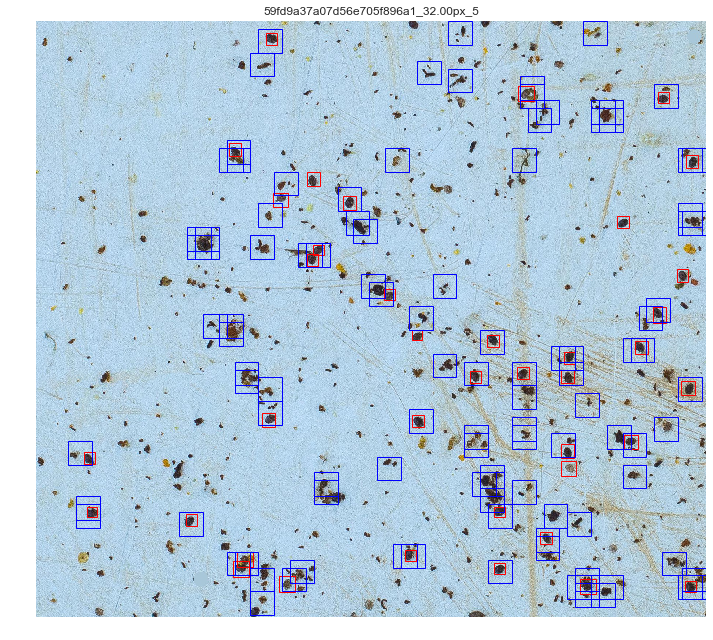

In [145]:
def detect_by_cnn(img,n_sliding,name_model):
#     name_model = 'my-model-2000'
    win_size = 60
    count = 0
#     n_sliding = 3 #half window sliding
    [x_len,y_len,_] = np.shape(img)
    x_len_win = x_len*n_sliding - window_size*(n_sliding-1)
    y_len_win = y_len*n_sliding - window_size*(n_sliding-1)
    imported_graph = tf.train.import_meta_graph(name_model + '.meta')
    
    labels_ = []
    
    with tf.Session(graph=CNN_GRAPH) as session:
        # Restore variables from disk.
        imported_graph.restore(session, './' + name_model)
#         print("Model restored.")
        for i in range(int(np.ceil(x_len_win/win_size))):
            for j in range(int(np.ceil(y_len_win/win_size))):
                #One window on the image
                indx = win_size//n_sliding*i
                indy = win_size//n_sliding*j
                if (indx+win_size>=x_len):
                    indx = x_len-win_size
                if (indy+win_size>=y_len):
                    indy = y_len-win_size
                window = img[indx:indx+win_size, indy:indy+win_size, :]   
                FEED_DICT_TEST = {TF_TRAIN_DATASET: [np.ndarray.flatten(window)], TF_TRAIN_LABELS: [[0,1]]}
                aux = TRAIN_PREDICTION.eval(session=session,feed_dict=FEED_DICT_TEST)[0]
                if aux[0] == 1.00:
                    labels_.append([indy, indx , window_size, window_size])
                    count+=1
        return labels_, count
n=27
TESTING = 0
TRAINNING = 1
VALIDATION = 2
name_model = 'my-model-20'
n_sliding = 3
labels,c = detect_by_cnn(valid_images[n],n_sliding,name_model)
print(c,np.shape(valid_annotations_xmls[n])[0])
plot_images_labels(n,VALIDATION,labels)
# labels,c = detect_by_cnn(train_images_all[n],n_sliding,name_model)
# print(c,np.shape(train_annotations_xmls[n])[0])
# plot_images_labels(n,TRAINNING,labels)


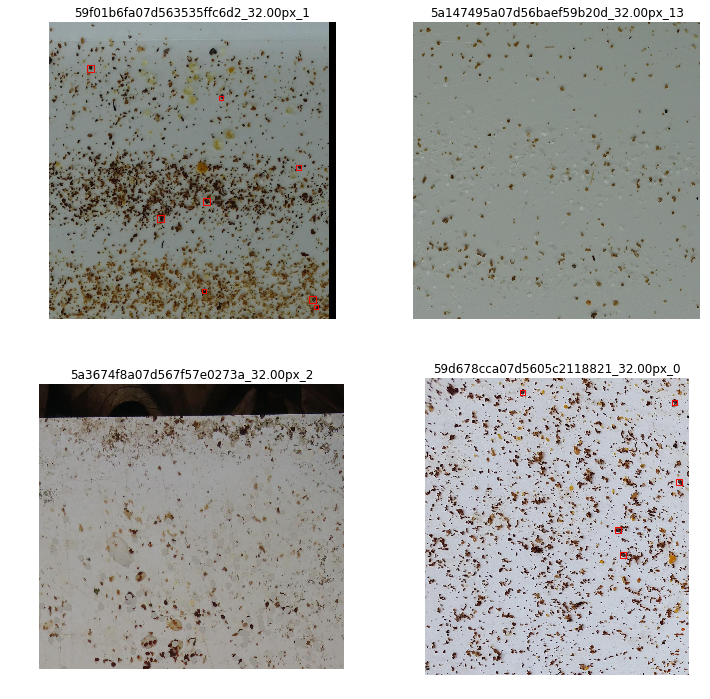

In [61]:
plot_images(8,TRAINNING)

In [122]:
name_model = 'my-model-20'
n_sliding = 3
T=0.3
results = np.zeros([3,np.shape(valid_annotations_xmls)[0]])

prec_av = 0
rec_av = 0 
F1_av = 0

k1 = np.shape(valid_annotations_xmls)[0]
# k1 = 5
k2 = 0

for n in range(k2, k2+k1):
#     print(detect_by_cnn(valid_images[n],n_sliding,name_model))
    labels,nbr_detected_varroas = detect_by_cnn(valid_images[n],n_sliding,name_model)
    IoU = IoU_eval(valid_annotations_xmls[n], np.array(labels))
#         print(len(labels),nbr_detected_varroas)
    TP, FP, FN = number_of_TP_FP_FN_eval(IoU, T, len(labels))
    prec, rec, F1 = precision_recall_F1score_eval(TP, FP, FN)
    results[:,n] = [prec, rec, F1]
    prec_av += prec
    rec_av += rec
    F1_av += F1

    print (prec, rec, F1, TP, FP, FN)

prec_av /= k1
rec_av /= k1
F1_av /= k1
    
    


INFO:tensorflow:Restoring parameters from ./my-model-20
0.0 1 0.0 0 6 0
INFO:tensorflow:Restoring parameters from ./my-model-20
0.0 1 0.0 0 2 0
INFO:tensorflow:Restoring parameters from ./my-model-20
0.0 1 0.0 0 1 0
INFO:tensorflow:Restoring parameters from ./my-model-20
0.0 0.0 0 0 1 1
INFO:tensorflow:Restoring parameters from ./my-model-20
0.0 1 0.0 0 4 0
INFO:tensorflow:Restoring parameters from ./my-model-20
0.0 0.0 0 0 14 7
INFO:tensorflow:Restoring parameters from ./my-model-20
0.0 0.0 0 0 25 24
INFO:tensorflow:Restoring parameters from ./my-model-20
0.0 1 0.0 0 2 0
INFO:tensorflow:Restoring parameters from ./my-model-20
0.0 0.0 0 0 2 1
INFO:tensorflow:Restoring parameters from ./my-model-20
0.0 1 0.0 0 2 0
INFO:tensorflow:Restoring parameters from ./my-model-20
0.0 0.0 0 0 36 5
INFO:tensorflow:Restoring parameters from ./my-model-20
0.0 0.0 0 0 31 18
INFO:tensorflow:Restoring parameters from ./my-model-20
1 1 1.0 0 0 0
INFO:tensorflow:Restoring parameters from ./my-model-20
0.0 

0.0 0.0 0 0 1 1
INFO:tensorflow:Restoring parameters from ./my-model-20
0.0 1 0.0 0 2 0
INFO:tensorflow:Restoring parameters from ./my-model-20
0.0 0.0 0 0 25 8
INFO:tensorflow:Restoring parameters from ./my-model-20
0.0 0.0 0 0 49 1
INFO:tensorflow:Restoring parameters from ./my-model-20
0.0 0.0 0 0 28 10
INFO:tensorflow:Restoring parameters from ./my-model-20
0.025 0.058823529411764705 0.03508771929824561 1 39 16
INFO:tensorflow:Restoring parameters from ./my-model-20
1 1 1.0 0 0 0
INFO:tensorflow:Restoring parameters from ./my-model-20
0.0 0.0 0 0 26 8
INFO:tensorflow:Restoring parameters from ./my-model-20
1 1 1.0 0 0 0
INFO:tensorflow:Restoring parameters from ./my-model-20
0.0 0.0 0 0 10 2
INFO:tensorflow:Restoring parameters from ./my-model-20
0.0 0.0 0 0 2 2
INFO:tensorflow:Restoring parameters from ./my-model-20
0.0 1 0.0 0 50 0
INFO:tensorflow:Restoring parameters from ./my-model-20
0.0 0.0 0 0 27 8
INFO:tensorflow:Restoring parameters from ./my-model-20
0.0 0.0 0 0 9 5
INFO:

Results average using the windows as the rectangles surrounding the varroas

In [149]:
print('Precision, Recall, F1')
print(prec_av, rec_av, F1_av)

Precision, Recall, F1
0.10020194003527337 0.3137902151151723 0.08694624689577825


In [135]:
def extract_size_varroa(img):
    
    image= np.uint8((img[:,:,0]/3*2+img[:,:,1]/3)).copy()
    
    image = skimage.filters.median(image, square(3))
    
    thresh = 70
    image = image > thresh
    
    y_image, x_image = image.shape
    
    x_min = x_image
    x_max = 0
    y_min = y_image
    y_max = 0
    for x in range(0,x_image):
        for y in range(0,y_image):
            if image[y,x]==0:
                if x < x_min:
                    x_min = x
                if x > x_max:
                    x_max = x
                if y < y_min:
                    y_min = y
                if y > y_max:
                    y_max = y
    
    h_old = (y_max-y_min)
    w_old = (x_max-x_min)
    increment = 1
    h = (y_max-y_min)*increment
    w = (x_max-x_min)*increment
    x_min = x_min+w_old/2-w/2
    y_min = y_min+h_old/2-h/2
    
    return int(x_min), int(y_min), int(w), int(h)

def detect_by_cnn2(img,n_sliding,name_model):
    win_size = 60
    count = 0
    [x_len,y_len,_] = np.shape(img)
    x_len_win = x_len*n_sliding - window_size*(n_sliding-1)
    y_len_win = y_len*n_sliding - window_size*(n_sliding-1)
    imported_graph = tf.train.import_meta_graph(name_model + '.meta')
    
    labels_ = []
    
    with tf.Session(graph=CNN_GRAPH) as session:
        imported_graph.restore(session, './' + name_model)
        for i in range(int(np.ceil(x_len_win/win_size))):
            for j in range(int(np.ceil(y_len_win/win_size))):
                indx = win_size//n_sliding*i
                indy = win_size//n_sliding*j
                if (indx+win_size>=x_len):
                    indx = x_len-win_size
                if (indy+win_size>=y_len):
                    indy = y_len-win_size
                window = img[indx:indx+win_size, indy:indy+win_size, :]   
                FEED_DICT_TEST = {TF_TRAIN_DATASET: [np.ndarray.flatten(window)], TF_TRAIN_LABELS: [[0,1]]}
                aux = TRAIN_PREDICTION.eval(session=session,feed_dict=FEED_DICT_TEST)[0]
                if aux[0] == 1.00:
                    [b1, b2, b3, b4] = extract_size_varroa(window)
                    labels_.append([indy+b1, indx+b2, b3, b4])
#                     labels_.append([indy, indx , window_size, window_size])
                    count+=1
        return labels_, count

In [152]:
name_model = 'my-model-20'
n_sliding = 1
T=0.3
results2 = np.zeros([3,np.shape(valid_annotations_xmls)[0]])

prec_av2 = 0
rec_av2 = 0 
F1_av2 = 0

k1 = np.shape(valid_annotations_xmls)[0]
# k1 = 75
k2 = 0

for n in range(k2, k2+k1):
    labels,nbr_detected_varroas = detect_by_cnn2(valid_images[n],n_sliding,name_model)
    IoU = IoU_eval(valid_annotations_xmls[n], np.array(labels))
    TP, FP, FN = number_of_TP_FP_FN_eval(IoU, T, len(labels))
    prec, rec, F1 = precision_recall_F1score_eval(TP, FP, FN)
    results2[:,n] = [prec, rec, F1]
    prec_av2 += prec
    rec_av2 += rec
    F1_av2 += F1

    print (prec, rec, F1, TP, FP, FN,n)

prec_av2 /= k1
rec_av2 /= k1
F1_av2 /= k1
    
    
print(prec_av2, rec_av2, F1_av2)
#     print (prec, rec, F1)

INFO:tensorflow:Restoring parameters from ./my-model-20
0.0 1 0.0 0 2 0 0
INFO:tensorflow:Restoring parameters from ./my-model-20
1 1 1.0 0 0 0 1
INFO:tensorflow:Restoring parameters from ./my-model-20
1 1 1.0 0 0 0 2
INFO:tensorflow:Restoring parameters from ./my-model-20
1 0.0 0.0 0 0 1 3
INFO:tensorflow:Restoring parameters from ./my-model-20
1 1 1.0 0 0 0 4
INFO:tensorflow:Restoring parameters from ./my-model-20
0.0 0.0 0 0 2 7 5
INFO:tensorflow:Restoring parameters from ./my-model-20
0.2 0.041666666666666664 0.06896551724137931 1 4 23 6
INFO:tensorflow:Restoring parameters from ./my-model-20
1 1 1.0 0 0 0 7
INFO:tensorflow:Restoring parameters from ./my-model-20
1 0.0 0.0 0 0 1 8
INFO:tensorflow:Restoring parameters from ./my-model-20
1 1 1.0 0 0 0 9
INFO:tensorflow:Restoring parameters from ./my-model-20
0.125 0.2 0.15384615384615385 1 7 4 10
INFO:tensorflow:Restoring parameters from ./my-model-20
0.16666666666666666 0.05555555555555555 0.08333333333333333 1 5 17 11
INFO:tensorfl

0.0 1 0.0 0 4 0 100
INFO:tensorflow:Restoring parameters from ./my-model-20
1 1 1.0 0 0 0 101
INFO:tensorflow:Restoring parameters from ./my-model-20
1.0 0.13333333333333333 0.23529411764705882 2 0 13 102
INFO:tensorflow:Restoring parameters from ./my-model-20
1.0 0.3333333333333333 0.5 1 0 2 103
INFO:tensorflow:Restoring parameters from ./my-model-20
0.0 0.0 0 0 1 6 104
INFO:tensorflow:Restoring parameters from ./my-model-20
1 1 1.0 0 0 0 105
INFO:tensorflow:Restoring parameters from ./my-model-20
1 0.0 0.0 0 0 6 106
INFO:tensorflow:Restoring parameters from ./my-model-20
0.0 0.0 0 0 2 6 107
INFO:tensorflow:Restoring parameters from ./my-model-20
1.0 0.16666666666666666 0.2857142857142857 1 0 5 108
INFO:tensorflow:Restoring parameters from ./my-model-20
0.0 0.0 0 0 11 25 109
INFO:tensorflow:Restoring parameters from ./my-model-20
1 0.0 0.0 0 0 5 110
INFO:tensorflow:Restoring parameters from ./my-model-20
0.0 0.0 0 0 26 4 111
INFO:tensorflow:Restoring parameters from ./my-model-20
1 0.

INFO:tensorflow:Restoring parameters from ./my-model-20
108 39


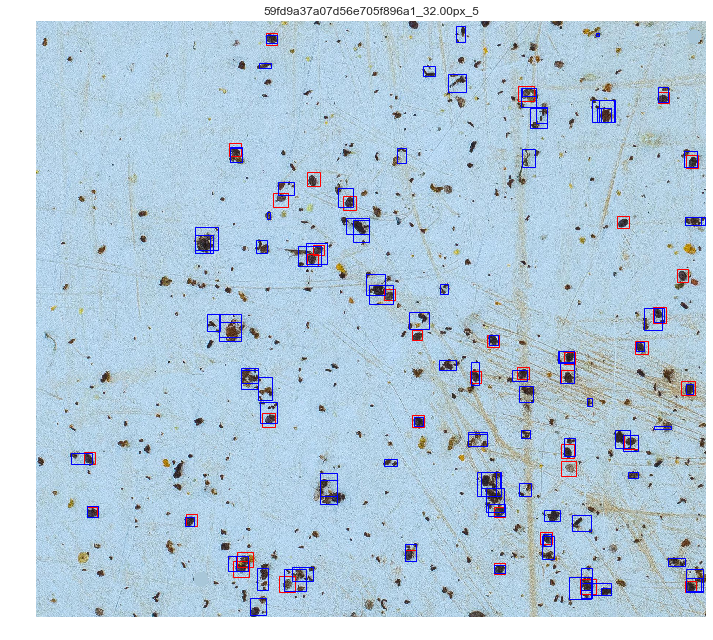

In [144]:
n=27
TESTING = 0
TRAINNING = 1
VALIDATION = 2
name_model = 'my-model-20'
n_sliding = 3
labels,c = detect_by_cnn2(valid_images[n],n_sliding,name_model)
print(c,np.shape(valid_annotations_xmls[n])[0])
plot_images_labels(n,VALIDATION,labels)

Results after modifying the rectangles

In [153]:
print('Precision, Recall, F1')
print(prec_av2, rec_av2, F1_av2)

Precision, Recall, F1
0.45667777777777785 0.33508116587419806 0.2517450657776126


## Challenge

You can generate a json submission file by using the function ''**generate_pred_json**''. This prediction file can be uploaded online for evaluation (Please refer to section 3 of the project description for more details).

In [45]:
import numpy as np
import json

def generate_pred_json(data, tag='baseline'):
    '''
    Input
    - data: Is a dictionary d, such that:
          d = { 
              "ID_1": [], 
              "ID_2": [[x_21, y_21, w_21, h_21], [x_22, y_22, w_22, h_22]], 
              ... 
              "ID_i": [[x_i1, y_i1, w_i1, h_i1], ..., [x_iJ, y_iJ, w_iJ, h_iJ]],
              ... 
              "ID_N": [[x_N1, y_N1, w_N1, h_N1]],
          }
          where ID is the string id of the image (e.i. 5a05e86fa07d56baef59b1cb_32.00px_1) and the value the Kx4 
          array of intergers for the K predicted bounding boxes (e.g. [[170, 120, 15, 15]])
    - tag: (optional) string that will be added to the name of the json file.
    Output
      Create a json file, "prediction_[tag].json", conatining the prediction to EvalAI format.
    '''
    unvalid_key = []
    _data = data.copy()
    for key, value in _data.items():
        try:
            # Try to convert to numpy array and cast as closest int
            print(key)
            v = np.around(np.array(value)).astype(int)
            # Check is it is a 2d array with 4 columns (x,y,w,h)
            if v.ndim != 2 or v.shape[1] != 4:
                unvalid_key.append(key)
            # Id must be a string
            if not isinstance(key, str):
                unvalid_key.append(key)
            _data[key] = v.tolist()
        # Deal with not consistant array size and empty predictions
        except (ValueError, TypeError):
            unvalid_key.append(key)
    # Remove unvalid key from dictionnary
    for key in unvalid_key: del _data[key]
    
    with open('prediction_{}.json'.format(tag), 'w') as outfile:
        json.dump(_data, outfile)

In [7]:
#Your code